In [1]:
from langgraph.graph import StateGraph, END, START
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated
from dotenv import load_dotenv
import operator
import os
from langchain_core.prompts import PromptTemplate

c:\Users\ArkajyotiKarmakar\OneDrive - GyanSys Inc\Desktop\Langgraph\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
load_dotenv()

True

In [3]:
model = ChatGoogleGenerativeAI(
    model = 'gemini-2.5-flash',
    google_api_key = os.getenv('GEMINI_API_KEY')
)

In [4]:
class BatsmanStats(TypedDict):

    # runs: int
    # balls: int
    # fours : int
    # sixes : int
    runs: Annotated[int, operator.add]
    balls: Annotated[int, operator.add]
    fours: Annotated[int, operator.add]
    sixes: Annotated[int, operator.add]

    sr: float
    bpb: float
    boundary_percentage: float
    
    summary : str


In [5]:
def calculate_sr(state: BatsmanStats) -> BatsmanStats:

    runs = state['runs']
    balls = state['balls']

    strike_rate = (float)(runs / balls) * 100

    return {'sr': strike_rate}

In [6]:
def calculate_bpb(state: BatsmanStats) -> BatsmanStats:

    runs = state['runs']
    balls = state['balls']
    fours = state['fours']
    sixes = state['sixes']

    total = fours + sixes
    
    bpb = (float)(total / balls)

    return {'bpb': bpb}

In [7]:
def cal_percent(state: BatsmanStats) -> BatsmanStats:

    runs = state['runs']
    balls = state['balls']
    fours = state['fours']
    sixes = state['sixes']

    total_runs = fours * 4 + sixes * 6

    # Calculating boundary percentage

    percent = (float)((total_runs / runs) * 100 )

    return {'boundary_percentage' : percent}

In [8]:
def gen_summary(state: BatsmanStats) -> BatsmanStats:

    sr = state['sr']
    bpb = state['bpb']
    percent = state['boundary_percentage']
    runs = state['runs']
    balls = state['balls']
    fours = state['fours']
    sixes = state['sixes']
    
    prompt = f"Generate a detailed summary which tells about the metrics as if in a Cricket Commentary style : Strike Rate - {sr} , Boundary Percentage - {percent}, Balls Per Boundary - {bpb} , Runs - {runs}, Sixes - {sixes}, Fours - {fours}, balls - { balls} in Hindi"

    result = model.invoke(prompt).content
    
    return {'summary': result}

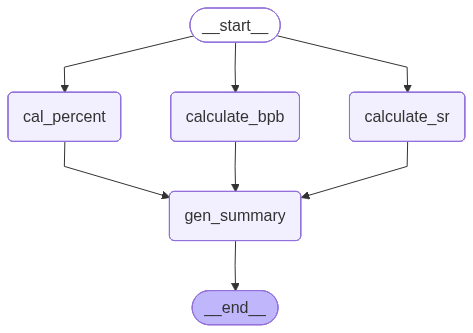

In [12]:
graph = StateGraph(BatsmanStats)

graph.add_node('calculate_sr', calculate_sr)
graph.add_node('calculate_bpb', calculate_bpb)
graph.add_node('cal_percent', cal_percent)
graph.add_node('gen_summary', gen_summary)

graph.add_edge( START, 'calculate_sr')
graph.add_edge( START, 'calculate_bpb')
graph.add_edge( START, 'cal_percent')
graph.add_edge( 'calculate_sr', 'gen_summary')
graph.add_edge( 'calculate_bpb', 'gen_summary')
graph.add_edge( 'cal_percent', 'gen_summary')
graph.add_edge( 'gen_summary', END )

workflow = graph.compile()
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())


In [11]:
initial_state = {
    'runs': 85,
    'balls': 52,
    'fours': 8,
    'sixes': 6
}

final_State = workflow.invoke(initial_state)
print(final_State)

{'runs': 85, 'balls': 52, 'fours': 8, 'sixes': 6, 'sr': 163.46153846153845, 'bpb': 0.2692307692307692, 'boundary_percentage': 80.0, 'summary': 'वाह! क्या शानदार आंकड़े हैं! आइए, इन आंकड़ों को एक तूफानी क्रिकेट कमेंट्री के अंदाज़ में समझते हैं:\n\n**(कमेंटेटर 1, उत्साह से)**\n"नमस्कार दर्शकों! क्रिकेट के मैदान से एक बार फिर हम हाज़िर हैं आपके साथ, और आज हम जिस पारी की चर्चा करने जा रहे हैं, वो सिर्फ आंकड़े नहीं, बल्कि एक तूफानी प्रदर्शन की गाथा है! गेंदबाज़ों के लिए ये किसी बुरे सपने से कम नहीं रही होगी!"\n\n**(कमेंटेटर 2, आंकड़ों पर ज़ोर देते हुए)**\n"बिल्कुल सही कहा आपने! देखिए, बल्लेबाज ने कुल **52 गेंदों** का सामना किया और बनाए **85 रन**! ये तो सिर्फ शुरुआत है, असली मज़ा तो अब आएगा!"\n\n**(कमेंटेटर 1, स्ट्राइक रेट पर फोकस करते हुए)**\n"और इन 85 रनों को बनाने के लिए जो अंदाज़ अपनाया गया, वो था एकदम तेज़ तर्रार! **स्ट्राइक रेट देखिए - 163.46!** ये बताता है कि बल्लेबाज ने एक भी गेंद बर्बाद नहीं की, हर गेंद को रन बनाने के इरादे से देखा और उसे बाउंड्री पार पहुंचाने की कोशिश की!"\n\n**(कम